* importing library 

In [203]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

* loading and understanding data

In [204]:
shared_articles_df = pd.read_csv(r'C:\Projects\recommender-systems\Dataset\shared_articles.csv')

In [205]:
shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [206]:
shared_articles_df.shape

(3122, 13)

* There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.


eventType
CONTENT SHARED     3047
CONTENT REMOVED      75
Name: count, dtype: int64


<Axes: xlabel='eventType', ylabel='count'>

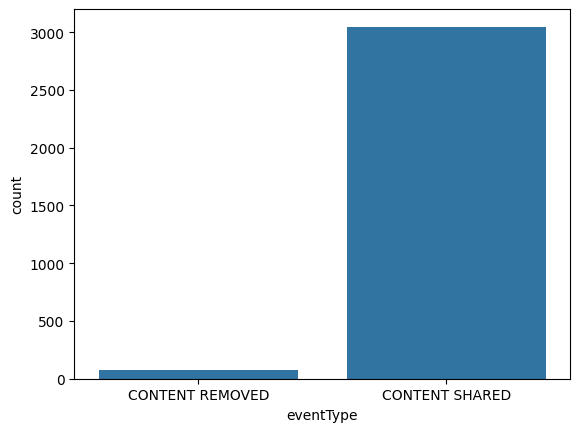

In [207]:
print(shared_articles_df['eventType'].value_counts())
sns.countplot(x=shared_articles_df['eventType'],data=shared_articles_df)

In [208]:
shared_articles_df = shared_articles_df[shared_articles_df['eventType'] == 'CONTENT SHARED']
shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [209]:
user_interaction_df = pd.read_csv(r'C:\Projects\recommender-systems\Dataset\users_interactions.csv')
user_interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [210]:
user_interaction_df.shape

(72312, 8)

eventType
VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: count, dtype: int64


<Axes: xlabel='eventType', ylabel='count'>

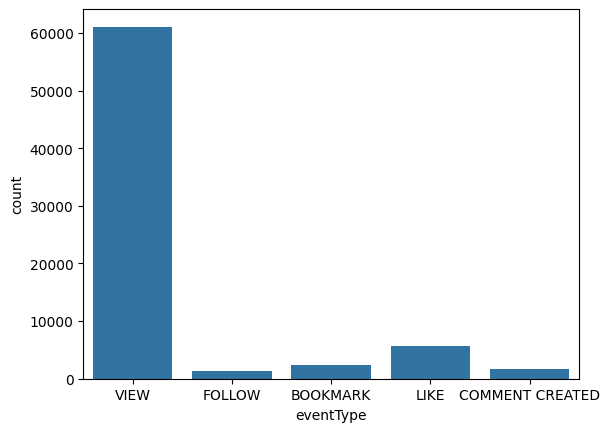

In [211]:
print(user_interaction_df['eventType'].value_counts())
sns.countplot(x=user_interaction_df['eventType'],data=user_interaction_df)

* As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [212]:
event_type_dict = {
    'VIEW' : 1.0 ,
    'LIKE' : 2.0 ,
    'BOOKMARK' : 3.0 , 
    'FOLLOW' : 4.0 ,
    'COMMENT CREATED' : 5.0
}

user_interaction_df['new_event_type'] = user_interaction_df['eventType'].map(event_type_dict)

In [213]:
user_interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,4.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


* Users Can interact with aticles multiple times 

In [214]:
user_interaction_df.groupby(['personId', 'contentId']).size().head()

personId              contentId           
-9223121837663643404  -8949113594875411859    1
                      -8377626164558006982    1
                      -8208801367848627943    1
                      -8187220755213888616    1
                      -7423191370472335463    8
dtype: int64

In [215]:
user_interaction_df[(user_interaction_df['personId']==-9223121837663643404) & (user_interaction_df['contentId']==-7423191370472335463)].sort_values(by=['timestamp'])

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
60988,1478687166,VIEW,-7423191370472335463,-9223121837663643404,2411828781515959462,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
64003,1478705793,VIEW,-7423191370472335463,-9223121837663643404,2411828781515959462,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
61256,1478795892,VIEW,-7423191370472335463,-9223121837663643404,-4096620279830729916,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63155,1478860184,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63183,1478860897,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63180,1478862151,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
65167,1479290925,VIEW,-7423191370472335463,-9223121837663643404,-8865295409778928525,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63834,1479376578,VIEW,-7423191370472335463,-9223121837663643404,-6084152871682607649,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0


In [216]:
user_interaction_df[(user_interaction_df['personId']==9210530975708218054) & (user_interaction_df['contentId']==8477804012624580461)].sort_values(by=['timestamp'])

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
68300,1486577685,VIEW,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
68290,1486577725,BOOKMARK,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,3.0
68291,1486577726,LIKE,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,2.0
68297,1486577729,FOLLOW,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,4.0


* Recommender systems have a problem known as ***user cold-start***, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [217]:
# Calculates the number of users based on the number of content they have interacted with
users_interactions_count_df = user_interaction_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))

# users: 1895


In [218]:
# The code counts and displays the number of users who have had five or more interactions with the content.
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1140


In [219]:
print('# of interactions: %d' % len(user_interaction_df))

# of interactions: 72312


In [220]:
# Counts the number of interactions made by users who have five or more interactions with the content.
interactions_from_selected_users_df = user_interaction_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 69868


In [221]:
interactions_from_selected_users_df.groupby(['eventType','new_event_type']).size()

eventType        new_event_type
BOOKMARK         3.0                2420
COMMENT CREATED  5.0                1579
FOLLOW           4.0                1379
LIKE             2.0                5625
VIEW             1.0               58865
dtype: int64

In [222]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['new_event_type'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,new_event_type
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


* Evaluation 

In [223]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In [224]:
# Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [225]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [226]:
#  Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def __init__(self, interactions_test_indexed_df):
        self.interactions_test_indexed_df = interactions_test_indexed_df

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(shared_articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        # Convert set to list before sampling
        non_interacted_items_list = list(non_interacted_items)
    
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items_list, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator(interactions_test_indexed_df)    

In [227]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['new_event_type'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,new_event_type
0,-4029704725707465084,310.791362
1,-6783772548752091658,237.145410
2,-133139342397538859,229.089057
3,-8208801367848627943,199.660338
4,-6843047699859121724,196.174998
5,8224860111193157980,191.584205
6,-2358756719610361882,186.528260
7,2581138407738454418,182.495414
8,7507067965574797372,181.070143
9,1469580151036142903,172.066596


In [228]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('new_event_type', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['new_event_type', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, shared_articles_df)

In [229]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2420097161851189, 'recall@10': 0.37202761442086424}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,33,73,0.273973,0.452055,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,19,69,0.202899,0.275362,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


In [230]:
shared_articles_df['lang'].value_counts()

lang
en    2211
pt     829
la       3
es       2
ja       2
Name: count, dtype: int64

* Content-Based Filtering model

In [231]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = shared_articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(shared_articles_df['title'] + "" + shared_articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638118 stored elements in Compressed Sparse Row format>

In [232]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['new_event_type']).reshape(-1, 1)
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    
    # Convert to numpy array before normalization
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg)
    
    # Normalize the user profile
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(shared_articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [233]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [234]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.298388
1,machine learning,0.246449
2,machine,0.237893
3,google,0.201425
4,data,0.170605
5,ai,0.156154
6,algorithms,0.115673
7,like,0.098125
8,language,0.088070
9,people,0.082088


In [235]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(shared_articles_df)

In [236]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16312963436461264, 'recall@10': 0.26118639734083354}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,15,24,192,0.078125,0.125000,3609194402293569455
17,18,29,134,0.134328,0.216418,-2626634673110551643
16,20,33,130,0.153846,0.253846,-1032019229384696495
10,32,46,117,0.273504,0.393162,-1443636648652872475
82,6,15,88,0.068182,0.170455,-2979881261169775358
161,11,23,80,0.137500,0.287500,-3596626804281480007
65,8,12,73,0.109589,0.164384,1116121227607581999
81,8,19,69,0.115942,0.275362,692689608292948411
106,3,9,69,0.043478,0.130435,-9016528795238256703
52,3,8,68,0.044118,0.117647,3636910968448833585


* Collaborative Filtering model
- Matrix Factorization

In [237]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='new_event_type').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
print(users_items_pivot_matrix[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [239]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [240]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [241]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [242]:
U.shape

(1140, 15)

In [243]:
Vt.shape

(15, 2926)

In [244]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [245]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 8.04135163e-03,  7.44256578e-04, -1.67901617e-02, ...,
         3.40275507e-03,  1.34887873e-02,  2.31844013e-03],
       [-2.33862909e-04, -3.47837746e-04, -2.80582928e-03, ...,
         2.33132436e-03, -1.37418969e-04, -1.80409702e-03],
       [-1.18793907e-02,  6.63819793e-03, -6.65330770e-03, ...,
         7.84203483e-03, -1.01827597e-02,  1.11758831e-02],
       ...,
       [-2.79335799e-02,  8.15628913e-03, -2.05967208e-02, ...,
        -1.02084874e-02,  1.38245272e-03,  9.02732771e-03],
       [-2.05942521e-02,  4.60906707e-03,  1.37341561e-02, ...,
         4.91322768e-03,  2.14419951e-03, -7.45483522e-03],
       [-1.13252995e-02,  3.73209610e-03,  1.43613853e-01, ...,
        -1.18795237e-02,  6.24218958e-02,  1.41113074e-02]])

In [246]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [247]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.138279,0.137371,0.136094,0.143370,0.136233,0.136697,0.136831,0.143052,0.136263,0.135138,...,0.136478,0.129214,0.137378,0.138938,0.139506,0.136401,0.135032,0.134333,0.135138,0.136155
-9216926795620865886,0.137479,0.137359,0.138125,0.137334,0.137415,0.137432,0.137417,0.137501,0.137674,0.137577,...,0.137404,0.138981,0.137456,0.137561,0.139106,0.137510,0.137665,0.138292,0.137903,0.137806
-9194572880052200111,0.135555,0.137089,0.136667,0.136978,0.139808,0.137239,0.140664,0.135638,0.134570,0.138063,...,0.138687,0.142793,0.138535,0.139449,0.154870,0.139662,0.140099,0.135138,0.138903,0.153150
-9192549002213406534,0.141372,0.137412,0.134219,0.136539,0.139294,0.138089,0.138757,0.144309,0.142802,0.137761,...,0.139616,0.165026,0.138252,0.136549,0.141647,0.138735,0.138964,0.136516,0.140238,0.147781
-9190737901804729417,0.139581,0.136905,0.138139,0.138051,0.137206,0.137655,0.137856,0.137837,0.134453,0.139556,...,0.137790,0.137684,0.137579,0.137428,0.133775,0.137301,0.137525,0.137632,0.138044,0.135815
-9189659052158407108,0.138247,0.138132,0.137604,0.137130,0.138352,0.137231,0.137932,0.137725,0.139929,0.139584,...,0.139963,0.147194,0.137141,0.137639,0.148719,0.138387,0.138903,0.139230,0.139713,0.145108
-9176143510534135851,0.142388,0.138063,0.139037,0.138436,0.137167,0.136903,0.139177,0.139910,0.144180,0.143620,...,0.137768,0.146052,0.135791,0.137520,0.136282,0.137407,0.137972,0.142330,0.140771,0.141475
-9172673334835262304,0.137977,0.137461,0.137715,0.137271,0.137444,0.137490,0.137548,0.137740,0.137065,0.137815,...,0.138024,0.139386,0.137458,0.137301,0.136540,0.137416,0.137791,0.137768,0.138239,0.136950
-9171475473795142532,0.139995,0.137308,0.137498,0.137124,0.137670,0.137568,0.138390,0.137039,0.136421,0.139854,...,0.138434,0.138679,0.137481,0.137450,0.135741,0.137597,0.138185,0.137348,0.138519,0.136625


In [248]:
len(cf_preds_df.columns)

1140

In [249]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, shared_articles_df)

In [250]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33137305037074916, 'recall@10': 0.4668882638711327}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,18,45,192,0.093750,0.234375,3609194402293569455
17,28,56,134,0.208955,0.417910,-2626634673110551643
16,16,35,130,0.123077,0.269231,-1032019229384696495
10,38,49,117,0.324786,0.418803,-1443636648652872475
82,40,48,88,0.454545,0.545455,-2979881261169775358
161,24,34,80,0.300000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,15,22,69,0.217391,0.318841,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,22,31,68,0.323529,0.455882,3636910968448833585


* Hybrid Recommender

In [251]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, shared_articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [252]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3401943237023779, 'recall@10': 0.4776272053183329}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,20,43,192,0.104167,0.223958,3609194402293569455
17,31,59,134,0.231343,0.440299,-2626634673110551643
16,21,35,130,0.161538,0.269231,-1032019229384696495
10,39,51,117,0.333333,0.435897,-1443636648652872475
82,40,50,88,0.454545,0.568182,-2979881261169775358
161,25,34,80,0.312500,0.425000,-3596626804281480007
65,23,32,73,0.315068,0.438356,1116121227607581999
81,17,21,69,0.246377,0.304348,692689608292948411
106,20,27,69,0.289855,0.391304,-9016528795238256703
52,22,31,68,0.323529,0.455882,3636910968448833585


In [253]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.163130,0.261186
Popularity,0.242010,0.372028
Collaborative Filtering,0.331373,0.466888
Hybrid,0.340194,0.477627


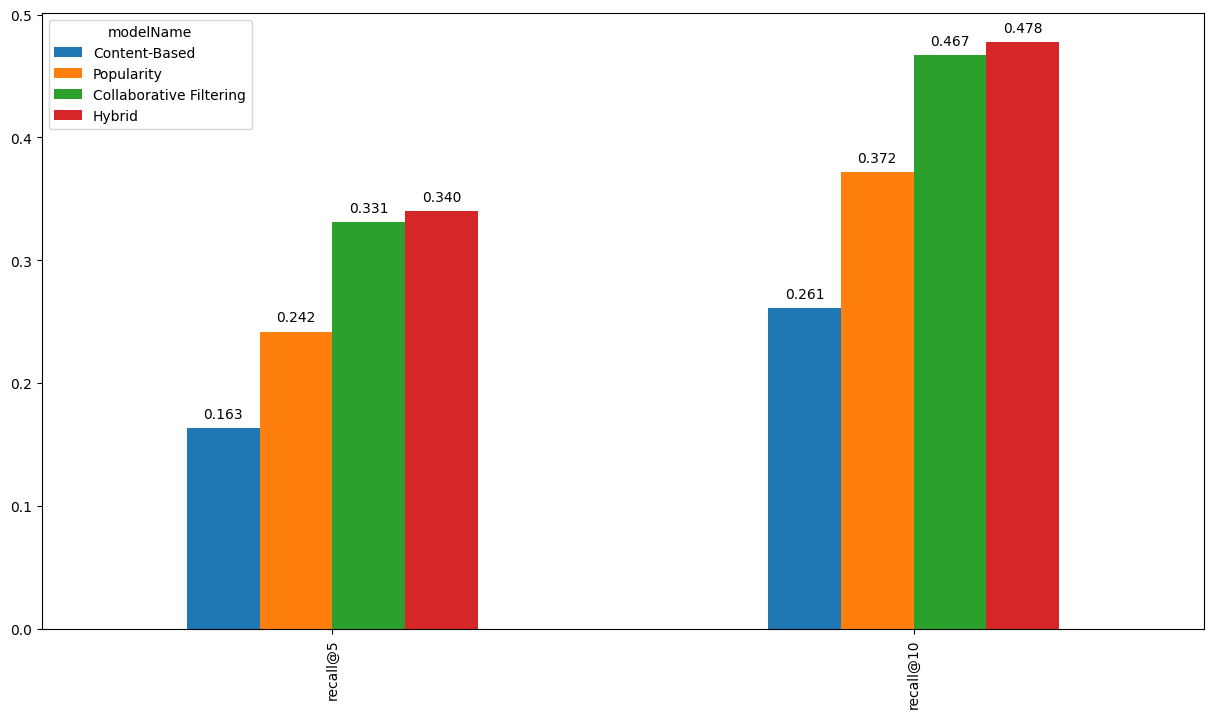

In [254]:

ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

* Testing

In [255]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(shared_articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('new_event_type', ascending = False)[['new_event_type', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [256]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,new_event_type,contentId,title,url,lang
115,4.459432,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
10,4.169925,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
38,4.169925,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.087463,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,4.000000,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
28,4.000000,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.906891,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.807355,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
43,3.700440,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
42,3.700440,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en


In [257]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,25.326243,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
1,25.250432,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
2,24.629258,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
3,24.457819,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
4,24.341284,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,24.217794,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,24.172918,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,23.970565,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
8,23.860891,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
9,23.740659,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en


In [258]:
import pickle
item_ids = pickle.dump( item_ids, open(r"C:\Projects\recommender-systems\Service\item_ids.p", "wb" ) )
user_profiles = pickle.dump( user_profiles, open(r"C:\Projects\recommender-systems\Service\user_profiles.p", "wb" ) )
tfidf_matrix = pickle.dump( tfidf_matrix, open(r"C:\Projects\recommender-systems\Service\tfidf_matrix.p", "wb" ) )
content_based_recommender_model = pickle.dump( content_based_recommender_model, open(r"C:\Projects\recommender-systems\Service\content_based_recommender_model.p", "wb" ) )